In [1]:
# setting device on GPU if available, else CPU
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print()

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

Using device: cuda

NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader

from torch.utils import data


import copy
import os
import random
import cv2
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import functools
from tqdm import tqdm
from datetime import datetime
import numpy as np
from functools import partial
# from core.datasets.vqa_motion_dataset import VQMotionDataset,DATALoader,VQVarLenMotionDataset,MotionCollator
from einops import rearrange, reduce, pack, unpack
import sys

In [4]:
def findAllFile(base):
    """
    Recursively find all files in the specified directory.

    Args:
        base (str): The base directory to start the search.

    Returns:
        list: A list of file paths found in the directory and its subdirectories.
    """
    file_path = []
    for root, ds, fs in os.walk(base, followlinks=True):
        for f in fs:
            fullname = os.path.join(root, f)
            file_path.append(fullname)
    return file_path

In [5]:
from utils.motion_processing.hml_process import recover_from_ric, recover_root_rot_pos
import utils.vis_utils.plot_3d_global as plot_3d
import matplotlib.pyplot as plt

## VQVAE

In [6]:
from core.datasets.vq_dataset import VQSMPLXMotionDataset
from core.datasets.vq_dataset import load_dataset, simple_collate
from configs.config import cfg, get_cfg_defaults
from core.datasets.conditioner import ConditionProvider
from core import MotionRep
from core.models.utils import instantiate_from_config, get_obj_from_str
from core.models.loss import ReConsLoss


/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def get_decoded(model , motion):
    encs = []
    inds = []
    for i in range(0 , motion.shape[1] , 120 ):
        if i + 240 >= motion.shape[1]:
            enc_b = model(motion[: , i:, :].to(device))
            encs.append(enc_b.decoded_motion)
            inds.append(enc_b.indices)
            break
        else:
            enc_b = model(motion[: , i:i + 120, :].to(device))
            encs.append(enc_b.decoded_motion)
            inds.append(enc_b.indices)
    return torch.cat(encs , 1), torch.cat(inds , -1)

In [8]:
dataset_names_default = [
    # "animation",
    # "humanml",
    # "perform",
    # "GRAB",
    "idea400",
    # "humman",
    # "beat",
    # "game_motion",
    # "music",
    # "aist",
    # "fitness",
    # "moyo",
    "choreomaster",
    # "dance",
    # "kungfu",
    # "EgoBody",
    # "HAA500",
]

In [9]:
def motion_dim(hml_rep, motion_rep, joints = 52, remove_trans=False):
    dim = 0

    if "g" in hml_rep:
        if remove_trans:
            dim += 2
        else:
            dim += 4
    if "p" in hml_rep:
        if motion_rep == MotionRep.BODY or motion_rep == MotionRep.FULL:
            dim += (joints - 1) * 3
        else:
            dim += (joints) * 3
    if "r" in hml_rep:
        if motion_rep == MotionRep.BODY or motion_rep == MotionRep.FULL:
            dim += (joints - 1) * 6
        else:
            dim += (joints) * 6
    if "v" in hml_rep:
        dim += joints * 3
    if "c" in hml_rep:
        dim += 4

    return dim

In [10]:
motion_dim("gprvc" , MotionRep.BODY , 22)

263

In [11]:
body_cfg = get_cfg_defaults()
body_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_full_gpvc/vqvae_full_gpvc.yaml")

In [12]:
dataset_args = body_cfg.dataset
model_args = body_cfg.vqvae

In [97]:
loss_fnc = ReConsLoss(
            recons_loss=model_args.recons_loss,
            use_geodesic_loss=model_args.use_geodesic_loss,
            nb_joints=model_args.nb_joints,
            hml_rep=dataset_args.hml_rep,
            motion_rep=MotionRep(dataset_args.motion_rep),
        )

In [14]:
body_model = instantiate_from_config(body_cfg.vqvae).to(device)
# body_model.load(os.path.join(body_cfg.output_dir, "vqvae_motion.pt"))

Sync is turned on False


In [15]:
# body_cfg.dataset.hml_rep = "gprv"
# body_cfg.dataset.window_size = -1

In [16]:
train_ds, sampler_train, weights_train = load_dataset(
            dataset_names=dataset_names_default,
            dataset_args=body_cfg.dataset,
            split="test",
        )

Total number of motions idea400: 577
Total number of motions choreomaster: 2


In [17]:

condition_provider = ConditionProvider(
            motion_rep=MotionRep(body_cfg.dataset.motion_rep),
            only_motion=True
        )
train_loader = torch.utils.data.DataLoader(
        train_ds,
        4,
        sampler=sampler_train,
        collate_fn=partial(simple_collate , conditioner = condition_provider),
    )

In [18]:
for batch in train_loader:
    break


In [19]:
batch["names"]

array(['idea400/subset_0034/Simultaneously_Drawing_And_Sitting.npy',
       'idea400/subset_0047/Dislike_And_Sitting_At_The_Same_Time.npy',
       'idea400/subset_0053/Simultaneously_Walking_And_Cooking_Rice_clip_1.npy',
       'idea400/subset_0040/Driving_During_Sitting.npy'], dtype='<U70')

In [20]:
gt_motion = batch["motion"][0].to(device)

In [21]:
gt_motion[0].shape

torch.Size([120, 317])

In [22]:
vqvae_output = body_model(gt_motion)

In [23]:
pred_motion = vqvae_output.decoded_motion

In [24]:
pred_motion.shape

torch.Size([4, 120, 317])

## Loss stuff

In [98]:
loss_fnc(gt_motion , pred_motion)

tensor(0.0797, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)

In [99]:
loss_fnc(gt_motion , pred_motion , simple = False)

tensor(0.9561, device='cuda:0', grad_fn=<AddBackward0>)

In [26]:
params_gt = torch.split(gt_motion, [4, 153, 156, 4], -1)

In [72]:
params_pred = torch.split(pred_motion, [4, 153, 156, 4], -1)

In [37]:
params_gt[-1][2][:,:2]

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1

torch.Size([4, 120, 52, 3])

In [93]:
fid_r, fid_l = [8, 11], [7, 10]
vel = params_gt[-2].contiguous().view(params_gt[-2].shape[:2] + (52 , 3))
pred_cl = (torch.sum(vel[: , : , fid_l]**2 , dim = -1)  - 0.002)
pred_cr = (torch.sum(vel[: , : , fid_r]**2 , dim = -1)   - 0.002 )
pred_c = torch.cat([pred_cl , pred_cr] , -1) 

In [94]:
vel2 = params_pred[-2].contiguous().view(params_pred[-2].shape[:2] + (52 , 3))
pred_cl2 = (torch.sum(vel2[: , : , fid_l]**2 , dim = -1)  - 0.002)
pred_cr2 = (torch.sum(vel2[: , : , fid_r]**2 , dim = -1)   - 0.002 )
pred_c2 = torch.cat([pred_cl2 , pred_cr2] , -1) 

In [90]:
pred_c.shape

torch.Size([4, 120, 4])

In [92]:
nn.functional.sigmoid(1e3*pred_c)[2]

tensor([[0.1362, 0.1337, 0.1417, 0.1486],
        [0.1257, 0.1235, 0.1333, 0.1287],
        [0.1212, 0.1203, 0.1368, 0.1244],
        [0.1205, 0.1205, 0.2200, 0.1857],
        [0.1227, 0.1211, 0.5022, 0.4564],
        [0.1243, 0.1220, 0.7181, 0.7111],
        [0.1297, 0.1231, 0.8875, 0.9029],
        [0.1262, 0.1220, 0.9042, 0.9424],
        [0.1218, 0.1212, 0.9466, 0.9769],
        [0.1228, 0.1199, 0.9726, 0.9917],
        [0.1261, 0.1198, 0.9896, 0.9977],
        [0.1254, 0.1202, 0.9889, 0.9973],
        [0.1250, 0.1213, 0.9884, 0.9969],
        [0.1224, 0.1206, 0.9422, 0.9743],
        [0.1200, 0.1202, 0.7925, 0.8594],
        [0.1210, 0.1205, 0.6797, 0.7429],
        [0.1223, 0.1214, 0.5596, 0.6007],
        [0.1225, 0.1295, 0.2403, 0.2365],
        [0.1314, 0.1492, 0.1412, 0.1275],
        [0.1254, 0.1372, 0.1253, 0.1219],
        [0.1217, 0.1282, 0.1207, 0.1242],
        [0.1323, 0.1215, 0.1313, 0.1201],
        [0.1897, 0.1448, 0.1773, 0.1306],
        [0.1626, 0.1378, 0.1313, 0

In [81]:
params_gt[-1][2]

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1.,

In [96]:
nn.functional.sigmoid(1e3*pred_c2)[2]

tensor([[0.1678, 0.1771, 0.2791, 0.1244],
        [0.1665, 0.1632, 0.3834, 0.1200],
        [0.1500, 0.1980, 0.3479, 0.1198],
        [0.1480, 0.2139, 0.3985, 0.1206],
        [0.1514, 0.2388, 0.4308, 0.1201],
        [0.1593, 0.2427, 0.4499, 0.1199],
        [0.1589, 0.2473, 0.4625, 0.1198],
        [0.1608, 0.2481, 0.4487, 0.1198],
        [0.1615, 0.2526, 0.4556, 0.1199],
        [0.1597, 0.2612, 0.4654, 0.1203],
        [0.1584, 0.2675, 0.4587, 0.1205],
        [0.1579, 0.2590, 0.4684, 0.1199],
        [0.1597, 0.2693, 0.4740, 0.1201],
        [0.1605, 0.2606, 0.4666, 0.1197],
        [0.1612, 0.2565, 0.4705, 0.1195],
        [0.1591, 0.2685, 0.4773, 0.1207],
        [0.1561, 0.2635, 0.4763, 0.1206],
        [0.1530, 0.2780, 0.4933, 0.1202],
        [0.1549, 0.2664, 0.5009, 0.1204],
        [0.1530, 0.2598, 0.4861, 0.1202],
        [0.1552, 0.2629, 0.4779, 0.1203],
        [0.1529, 0.2580, 0.4669, 0.1199],
        [0.1516, 0.2604, 0.4516, 0.1198],
        [0.1506, 0.2609, 0.4679, 0

In [95]:
nn.functional.binary_cross_entropy_with_logits(1e3*pred_c2 , params_gt[-1] )

tensor(1.4711, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [62]:
train_ds.datasets[0].render_hml(
                    pred_motion[0].detach().cpu(),
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/render_test.gif", from_rotation=True )

In [59]:
# !python train_vqvae.py

## Get indices

In [21]:
errors = []
for batch in tqdm(dl):
    sve = os.path.join("/srv/hays-lab/scratch/sanisetty3/motionx/indices/body_gpvc" , batch["names"][0] )
    if os.path.exists(sve):
        continue
    os.makedirs(os.path.dirname(sve) , exist_ok=True)
    try:
        if "g" in body_cfg.dataset.hml_rep:
            l = list(range(0, batch["motion"][0].shape[-1]))
            ohprvc = l[:1] + l[3:]
            gt_motion = batch["motion"][0][..., ohprvc]
        enc_b, inb = get_decoded(body_model , gt_motion.to(device))
        np.save(sve , inb.cpu().numpy())
    except:
        errors.append(batch["names"][0])
    

100%|██████████████████████████████████████████████████████████████████████████████████████| 6464/6464 [11:57<00:00,  9.01it/s]


In [22]:
len(errors)

9

## Translation

In [25]:
from core.datasets.translation_dataset import load_dataset,simple_collate
from configs.config import cfg, get_cfg_defaults
from core.datasets.conditioner import ConditionProvider
from core import MotionRep
from core.models.utils import instantiate_from_config, get_obj_from_str
import utils.rotation_conversions as geometry


In [7]:
from configs.config_t2o import cfg, get_cfg_defaults

In [8]:
body_cfg = get_cfg_defaults()
body_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/simple_motion_translation/simple_motion_translation.yaml")

In [9]:
dataset_args = body_cfg.dataset
model_args = body_cfg.vqvae

In [16]:
trans_model = instantiate_from_config(model_args).to(device).eval()
trans_model.load(os.path.join(body_cfg.output_dir, "tcn_model.pt"))

Sync is turned on False
loaded model with  0.0796232670545578 tensor([40000.], device='cuda:0') steps


In [74]:
train_ds, sampler_train, weights_train = load_dataset(
            dataset_names=["aist" , "beat"],
            dataset_args=body_cfg.dataset,
            split="train",
        )

Total number of motions aist: 1140
Total number of motions beat: 1454


In [76]:

condition_provider = ConditionProvider(
            motion_rep=MotionRep(body_cfg.dataset.motion_rep),
            only_motion=True
        )
train_loader = torch.utils.data.DataLoader(
        train_ds,
        4,
        sampler=sampler_train,
        collate_fn=partial(simple_collate , conditioner = condition_provider),
    )

In [65]:
def cossin2quat(r_rot):
    mat = torch.zeros(
        (
            r_rot.shape[:-1]
            + (
                3,
                3,
            )
        )
    ).to(r_rot.device)
    mat[..., 1, 1] = 1
    mat[..., 0, 0] = r_rot[..., 0]
    mat[..., 0, 2] = r_rot[..., 1]
    mat[..., 2, 0] = -r_rot[..., 1]
    mat[..., 2, 2] = r_rot[..., 0]
    r_rot_quat = geometry.matrix_to_quaternion(mat)
    return r_rot_quat

In [77]:
for batch in train_loader:
    break


In [98]:
batch["names"]

array(['aist/subset_0008/Dance_Middle_Hip-hop_Club_clip_2.npy',
       'beat/25_goto_0_81_81.npy',
       'aist/subset_0008/Dance_Middle_Hip-hop_Charleston_clip_5.npy',
       'beat/1_wayne_0_87_87.npy'], dtype='<U59')

In [78]:
gt_motion = batch["motion"][0].to(device)


In [79]:
gt_motion.shape

torch.Size([4, 120, 7])

In [80]:
rel_pos = gt_motion[..., 4:][..., [0, 2]]

In [81]:
r_rot = gt_motion[..., :4]
r_rot2 = geometry.quaternion_to_matrix(r_rot)[..., [0, 0], [0, 2]]

In [82]:
r_rot_rec = cossin2quat(r_rot2)

In [94]:
with torch.no_grad():
    out = trans_model(gt_motion)
    pred_traj = out.decoded_motion[...,:2]
    pred_orient = out.decoded_motion[...,2:]

In [91]:
with torch.no_grad():
    pred_quat = trans_model.predict(rel_pos)

torch.Size([120, 2])

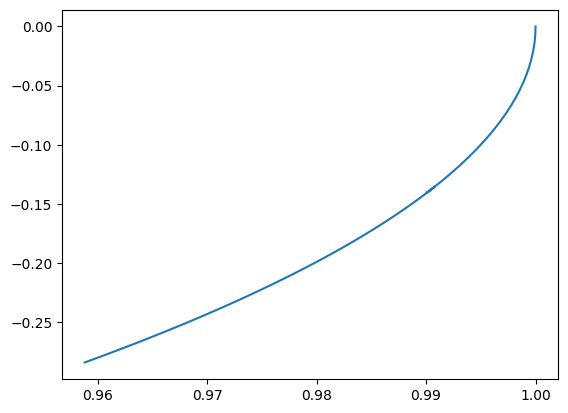

In [97]:
plt.plot(r_rot2[0].cpu()[: , 0] , r_rot2[0].cpu()[: , 1] )

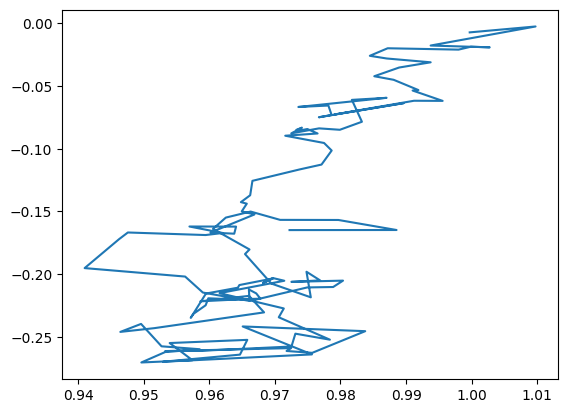

In [96]:
plt.plot(pred_orient[0].cpu()[: , 0] , pred_orient[0].cpu()[: , 1] )